In [1]:
%load_ext chime

import rasterio as rio
from rasterio.windows import from_bounds, transform
from rasterio.features import shapes
from rasterio.mask import mask
import numpy as np
import geopandas as gpd
import pandas as pd
import os
from shapely.geometry import Point, box, Polygon
import math
from rasterio.features import shapes
from datetime import datetime
import itertools
from datetime import datetime
from joblib import Parallel, delayed
from matplotlib import pyplot
from glob import glob
from shapely.geometry import MultiPolygon
import sys
import matplotlib.pyplot as plt
from utils import *
from math import ceil

boxesdf_loc = "../EPCExtent_30cm/Ortho_5kSubIndex.gpkg"
hag_tindex_loc = "../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_tindex.gpkg"
v3TrainingStack_dir = "../EPCExtent_30cm/Orthos_Segmentedv3"
ortho30cmvrt_loc = os.path.abspath("../EPCExtent_30cm/Orthos/EPC_30cmOrtho_2019.vrt")
hagvrt_loc = os.path.abspath("../EPCExtent_30cm/Elevation_80cmNPS/HAG_2015/HAG_2015.vrt")
histoEqual_loc = os.path.abspath("../EPCExtent_30cm/Orthos_LocalHistogramEqualized")



boxesdf = gpd.read_file(boxesdf_loc)
hag_tindex = gpd.read_file(hag_tindex_loc)
#rural_regions = gpd.read_file(ruralRegions_loc)

boxesdf = gpd.read_file(boxesdf_loc)
boxesdf["geometry"] = boxesdf["geometry"].apply(lambda g: box(*g.buffer(-50).bounds))

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


In [2]:
#def getSamplesInGroup(orthoSegFile, propsSegFile, group):
def getFeatureValuesDF(geometry, landcoverClass, rioTrainingDataset, rioHistoDataset, trainingBandLookup, histoBandLookup, ratioSample, x_values, y_values):
    datads, datads_trans = mask(rioTrainingDataset, geometry, all_touched=False, crop=False, filled=False)
    datads_mask = np.all(datads.mask, axis=0)  # RASTERIO MASK DOESN'T HANDLE TRUE 0 VALUES APPROPRIATLY BEHIND THE SCENES, ENSURE MASKS ACROSS BANDS AGREE
    #propsds, propsds_trans = mask(propsSegDataset, geom, all_touched=False, crop=False, filled=False)
    lheds, lheds_trans = mask(rioHistoDataset, geometry, all_touched=False, crop=False, filled=False)
    lheds_mask = np.all(lheds.mask, axis=0)  # RASTERIO MASK DOESN'T HANDLE TRUE 0 VALUES APPROPRIATLY BEHIND THE SCENES, ENSURE MASKS ACROSS BANDS AGREE

    dsshape = datads.data[0].shape

    # get masked array values for each feature for each band
    values_dict = {}
    for band_name, band_number in trainingBandLookup.items():
        indexNumber = band_number - 1
        values_dict[band_name] = datads.data[indexNumber][datads_mask]
    for band_name, band_number in histoBandLookup.items():
        indexNumber = band_number - 1
        values_dict[band_name] = lheds.data[indexNumber][lheds_mask]

    values_dict["X"] = x_values[datads_mask]
    values_dict["Y"] = y_values[datads_mask]
    """
    # get point locations of pixels in based on pixel offsets in dataset
    x_origin, y_origin = datads[2], datads[5]
    xs = np.array([[x_origin + (pix*reso) + reso/2] for pix in range(dsshape[1])])
    ys = np.array([[y_origin - (pix*reso) - reso/2] for pix in range(dsshape[0])])
    xs = np.moveaxis(xs, 0, -1)
    print("created x/y's")
    x_values = np.repeat(xs, repeats=dsshape[0], axis=0)
    y_values = np.repeat(ys, repeats=dsshape[1], axis=1)
    values_dict["X"] = x_values[datads_mask]
    values_dict["Y"] = y_values[datads_mask]
    print("pushed x/ys to dict")
    """
    featureDF = pd.DataFrame.from_dict(values_dict)

    # (135/255) * np.iinfo(np.uint16).max = 34695
    # (115/255) * np.iinfo(np.uint16).max = 29555
    # some polygons (e.g. roads) might have veg overhanging. Remove high msavi values. Also filter dense veg an irrigated
    if landcoverClass == "DenseVeg" or landcoverClass == "IrrigatedLand":
        featureDF = featureDF[featureDF.MSAVI > 34695]
    else:
        featureDF = featureDF[featureDF.MSAVI <= 34695]

    if landcoverClass == "SparseVeg":
        featureDF = featureDF[(featureDF.MSAVI > 29555) & (featureDF.MSAVI <= 34695)]
    elif landcoverClass == "Barren":
        featureDF = featureDF[featureDF.MSAVI <= 29555]

    # if the number of available values is greater than the calculated ratioed sample size, select a sub-sample.
    if len(featureDF) > ratioSample:
        featureDF = featureDF.sample(ratioSample)
    
    return featureDF
                    
def getSamplesInGroup(trainingDatasetFile, group):
    lcclass = group["LCClass"].values[0]
    
    path = group.path.values[0]
    row = group.row.values[0]
    
    localHisto_file = findFile(path, row, localHisto_dir)
    if localHisto_file == None:
        print("Unable to locate Histo File. Returning None")
        return None
    
    with rio.open(trainingDatasetFile) as trainingDataset:
        band_nums = [i+1 for i in range(trainingDataset.count)]
        band_descriptions = trainingDataset.descriptions
        band_lookup = dict(zip(band_descriptions, band_nums))
        reso = trainingDataset.res[0]

        # Create two arrays of x pixel locations and y pixel locations.
        x_origin, y_origin = trainingDataset.bounds.left, trainingDataset.bounds.top
        halfpix_offset = trainingDataset.res[0]/2
        xs = np.array([[x_origin + (pix*reso) + halfpix_offset] for pix in range(trainingDataset.width)])
        ys = np.array([[y_origin - (pix*reso) - halfpix_offset] for pix in range(trainingDataset.height)])
        xs = np.moveaxis(xs, 0, -1)
        x_values = np.repeat(xs, repeats=trainingDataset.height, axis=0)
        y_values = np.repeat(ys, repeats=trainingDataset.width, axis=1)
        
        with rio.open(localHisto_file) as localHistoDataset:
            lhe_band_nums = [i+1 for i in range(localHistoDataset.count)]
            lhe_tag_names = localHistoDataset.descriptions
            lhe_band_lookup = dict(zip(lhe_tag_names, lhe_band_nums))
            #print(f"GROUP SIZE {len(group)}")
            if len(group) > 40:
                # if group is too large (i.e. lots of feature in a given training tile), treat as one feature
                geom = group.unary_union
                if geom.type != "MultiPolygon":
                    geom = MultiPolygon([geom])
                numPixels = group["NumberPixels"].sum()
                ratioSample = group["RatioedSamplePixels"].sum()
                valuesDataFrame = getFeatureValuesDF(geom, landcoverClass=lcclass,
                                                     rioTrainingDataset=trainingDataset, trainingBandLookup=band_lookup,
                                                     rioHistoDataset=localHistoDataset, histoBandLookup=lhe_band_lookup,
                                                     ratioSample=ratioSample,
                                                     x_values=x_values, y_values=y_values)
            else:
                tileDataFrames = []
                for i, row in group.reset_index(drop=True).iterrows():
                    print(f"Starting on group {i} of {len(group)} - {datetime.now()}")
                    try:
                        t1 = datetime.now()
                        geom = row.geometry
                        numPixels = row["NumberPixels"]
                        ratioSample = row["RatioedSamplePixels"]
                        
                        if geom.type != "MultiPolygon":
                            geom = MultiPolygon([geom])
                        
                        featureDF = getFeatureValuesDF(geom, landcoverClass=lcclass,
                                                       rioTrainingDataset=trainingDataset, trainingBandLookup=band_lookup,
                                                       rioHistoDataset=localHistoDataset, histoBandLookup=lhe_band_lookup,
                                                       ratioSample=ratioSample,
                                                       x_values=x_values, y_values=y_values)
                        
                        tileDataFrames.append(featureDF)
                        
                        #print(f"Done with index {i} in group {os.path.basename(trainingDatasetFile)} - {datetime.now()-t1}")
                        
                    except Exception as e:
                        print(f"Error with {lcclass} for {os.path.basename(trainingDatasetFile)} and geometry at {geom.centroid.wkt}\n{e}")
                    
                if len(tileDataFrames) > 0:
                    valuesDataFrame = pd.concat(tileDataFrames)
                else:
                    valuesDataFrame = tileDataFrames
                    
    return valuesDataFrame 

In [3]:
ruralRegions_loc = r"../OtherData/TrainingData/DesertBarrenVegetation_2015.gpkg"
pondsLakesPoly_loc = r"../OtherData/TrainingData/pondsLakesPolys.gpkg"
poolsPoly_loc  = r"../OtherData/TrainingData/poolsPolys.gpkg"
denseVeg_2015_loc = r"../OtherData/TrainingData/denseVeg_2015.gpkg"
irrigatedLand_2015_loc = r"../OtherData/TrainingData/irrigatedLand_2015.gpkg"
asphaultPoly_loc = "../OtherData/TrainingData/asphaultPoly.gpkg"
imperviousPoly_loc = "../OtherData/TrainingData/ImperviousPoly.gpkg"
structuresPoly_loc = r"../OtherData/TrainingData/StructuresPoly.gpkg"
parkingLotsPoly_loc = r"../OtherData/TrainingData/ParkingLots.gpkg"
sidewalks_loc = r"../OtherData/Amex_ADAAssetsRawCalcs_COT_Sidwalks.gpkg"

classes = {"PondLake": pondsLakesPoly_loc,
          "Pool": poolsPoly_loc,
          "DenseVeg": denseVeg_2015_loc,
          "IrrigatedLand": irrigatedLand_2015_loc,
          "Asphault": asphaultPoly_loc,
          "Impervious": imperviousPoly_loc,
          "Structure": structuresPoly_loc,
          "Barren": ruralRegions_loc,
          "SparseVeg": ruralRegions_loc,
          "ParkingLot": parkingLotsPoly_loc,
          "Sidewalk": sidewalks_loc}

In [4]:
%%time 
training_boxes_loc = "../Scripts/TrainingBoxes.gpkg"
if not os.path.exists(training_boxes_loc):
    print(f"Creating {training_boxes_loc}")
    dfs = []
    for lcclass, df_loc in classes.items():
        dfs.append(gpd.read_file(df_loc))
        
    boxes = []
    for i, df in enumerate(dfs):
        t = boxesdf[boxesdf.intersects(df.unary_union)]
        print(i, len(t))
        boxes.append(t)
    training_boxes = pd.concat(boxes)
    training_boxes.to_file("", driver="GPKG")
else:
    print(f"Reading in {training_boxes_loc}")
    training_boxes = gpd.read_file(training_boxes_loc)

training_boxes = training_boxes.dissolve(by="PR", as_index=False)
training_boxes["filepath"] = training_boxes.apply(lambda r: findFile(r.path, r.row, "../EPCExtent_30cm/Orthos_Segmentedv3"),axis=1)
print(training_boxes.shape)
print(training_boxes[pd.isnull(training_boxes.filepath)].shape)

Reading in ../Scripts/TrainingBoxes.gpkg


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


(1772, 7)
(0, 7)
Wall time: 13.5 s


In [5]:
def createTrainingData(df, data_dir):
    df["filepath"] = df.apply(lambda r: findFile(r.path, r.row, v3TrainingStack_dir),axis=1)
    outfiles = []
    todo = df[pd.isnull(df.filepath)]
    if len(todo)>0:
        print(f"{len(todo)} Training Datasets need to be built. Starting now ({datetime.now()})")
        outfiles += Parallel(n_jobs=6, verbose=5, backend="loky")(delayed(segmentWindowV3)(boxrow,
                                                                                           data_dir,
                                                                                           ortho30cmvrt_loc,
                                                                                           hagvrt_loc,
                                                                                           returnArray=False,
                                                                                           writeOutStack=True,
                                                                                           overwrite=False) for i, boxrow in todo.iterrows())
    
    df["filepath"] = df.apply(lambda r: findFile(r.path, r.row, data_dir), axis=1)
    todo = df[pd.isnull(df.filepath)]
    print(f"{len(todo)} Training Datasets Were Not Created. Removing them from training data")
    df = df[~pd.isnull(df.filepath)]
    
    print("Creating Histo Files")
    histoEqual_loc = "../EPCExtent_30cm/Orthos_LocalHistogramEqualized"
    histofiles += Parallel(n_jobs=6, verbose=5, backend="loky")(delayed(createLocalHistogramOrtho)(boxrow,
                                                                                                   histoEqual_loc,
                                                                                                   ortho30cmvrt_loc,
                                                                                                   overwrite=False) for i, boxrow in df.iterrows())
    return df


In [ ]:
lcPolys = createTrainingData(lcPolys, v3TrainingStack_dir)

In [7]:
# Based on file paths for segmented ortho files and segment properties files, create new columns in boxesdf for those file locations

boxesdf["PR"] = boxesdf.apply(lambda row: f"{row.path} {row.row}",axis=1)
boxesdf["filepath"] = boxesdf.apply(lambda r: findFile(r.path, r.row, "../EPCExtent_30cm/Orthos_Segmentedv3"), axis=1)

In [8]:
#day = datetime.now().strftime("%Y%m%d")
day = "20210819"

pointsPerClass = 5*1000000
lcSamples = {}
for lcClass, poly_loc in classes.items():
    outSamples_loc = f"../OtherData/TrainingData/{lcClass}_{day}.pickle"
    lcSamples[lcClass] = outSamples_loc
    
    if os.path.exists(outSamples_loc):
        print(f"File for {lcClass} already exists ({outSamples_loc}). Moving on...")
        continue
    else:
        t1 = datetime.now()
        print(f"Starting sample extraction for {lcClass} - {t1}")
    
        
    lcPolys = gpd.read_file(poly_loc)
    if len(lcPolys) > 50000:
        lcPolys = lcPolys.sample(50000)
        
    for col in lcPolys.columns.tolist():
        if col != "Area" and col != "geometry":
            del lcPolys[col]
    lcPolys["LCClass"] = lcClass
    
    print(f"Overlaying... - {datetime.now()}")
    # Join tile index to polygon features
    lcPolys = gpd.overlay(lcPolys, boxesdf, how="union")
    # Overlay return both geometries from over lay, remove non lcPoly rows and rows outside our boxesdf area (no path/row)
    lcPolys = lcPolys[(~pd.isnull(lcPolys.LCClass)) & (~pd.isnull(lcPolys.PR))]
    #lcPolys = lcPolys[~pd.isnull(lcPolys["OrthoSegFile"])]  
    break
    lcPolys = createTrainingData(lcPolys, v3TrainingStack_dir)
    
    with rio.open(lcPolys["filepath"].values[0]) as src:
        res = src.res[0]
        
    # calculate percentage of total (POT)
    lcPolys["Area"] = lcPolys.geometry.area.astype(int)
    lcPolys["NumberPixels"] = lcPolys.Area.apply(lambda area: area/(res**2))
    
    #1 Calculate Number of Samples per feature
    minSamples = int(lcPolys["NumberPixels"].min())
    totalPixels = lcPolys["NumberPixels"].sum()
    # from each feature, ensure that all area sampled at least as much as the smallest feature, then calculate the remainder to sample.
    remainderSamples = pointsPerClass - (minSamples * len(lcPolys))

    # Percentage of Total
    lcPolys["POT"] = lcPolys.NumberPixels.apply(lambda npix: npix/totalPixels)
    # Calculate number of samples to pull per features
    lcPolys["NumSamples"] = lcPolys["POT"].apply(lambda pot: int(minSamples+(pot*remainderSamples)))
    lcPolys["RatioedSamplePixels"] = lcPolys.NumSamples.apply(lambda ns: int(ns/(res**2)))
    
    # Group polygon features by tile index
    grps = lcPolys.groupby("filepath")
    print(f"{lcClass} - {len(grps)} file groups for {len(lcPolys)} polygons covering {round(lcPolys.Area.sum()/5280/5280,4)} square miles")
    print(f"Beginning extraction... {datetime.now()}")
    break
    lcDataFrames = Parallel(n_jobs=8, verbose=5)(delayed(getSamplesInGroup)(filepath, tileGroup) for filepath, tileGroup in lcPolys.groupby("filepath"))
    lcDataFrames = [df for df in lcDataFrames if type(df) == pd.core.frame.DataFrame]
    lcDataFrames = pd.concat(lcDataFrames)
    print(f"GOT ALL SAMPLES ({len(lcDataFrames)} total)- {datetime.now()- t1} elapsed")
    
    lcDataFrames["LCClass"] = lcClass
    lcSamples[lcClass] = outSamples_loc
    lcDataFrames.to_pickle(outSamples_loc)
    %chime
    
print("DONE")
%chime

File for PondLake already exists (../OtherData/TrainingData/PondLake_20210819.pickle). Moving on...
Starting sample extraction for Pool - 2021-08-20 11:53:13.094996


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


Overlaying... - 2021-08-20 11:53:15.541422
DONE


In [ ]:
for filepath, tileGroup in lcPolys.groupby("filepath"):
    print(filepath, tileGroup["PR"])
    t=getSamplesInGroup(filepath, tileGroup)
    break

In [49]:
from shapely.geometry import Point
df["geometry"] = df.apply(lambda r: Point(r.X, r.Y), axis=1)
df = gpd.GeoDataFrame(df, geometry="geometry", crs="epsg:2868")
df.to_file("PondsLakePoints_20210204.gpkg", driver="GPKG")

In [50]:
%chime

In [4]:
from datetime import datetime
march = datetime.strptime("20210325", "%Y%m%d")
may = datetime.strptime("20210527", "%Y%m%d")
may - march

datetime.timedelta(days=63)

In [53]:
#clean up samples by HAG values
trainingSamples = []
for lcClass, file in lcSamples.items():
    df = pd.read_pickle(file)
    if lcClass == "Structures":
        df = df[df.HAG != 0]
    elif lcClass == "PondsLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Asphault" or lcClass == "Impervious" or lcClass == "Barren":
        df = df[df.HAG == 0] 
    elif lcClass == "PondsLake":
        df = df[df.MSAVI<120]
        df = df[df.NDVI<15]
    elif lcClass == "Pool":
        df = df[df.MSAVI<100]
        df = df[df.NDVI<65]
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)
%chime

In [54]:
subsamp = trainingSamples.groupby('LCClass', group_keys=False).apply(lambda x: x.sample(200000))

subsamp.head()

,RED,GREEN,BLUE,NIR,MSAVI,NDVI,HAG,area,extent,eccentricity,perimeter,X,Y,LCClass
26414219,120,110,108,82,106,103,0,5760.0,0.672976,0.997940,722.657898,NaN,NaN,Asphault
34248147,87,83,89,46,101,88,0,29.0,0.580000,0.933841,23.414213,NaN,NaN,Asphault
32747769,145,137,135,90,98,97,0,11199.0,0.122691,0.995850,1282.312866,NaN,NaN,Asphault
25532930,60,57,67,20,98,63,0,59.0,0.921875,0.998362,58.207108,NaN,NaN,Asphault
35215537,120,113,110,85,108,105,0,134.0,0.638095,0.502580,63.313709,NaN,NaN,Asphault


In [55]:
trainingSamples.LCClass.unique()

array(['PondsLake', 'Pool', 'DenseVeg', 'IrrigatedLand', 'Asphault',
       'Impervious', 'Structures', 'Barren', 'SparseVeg'], dtype=object)

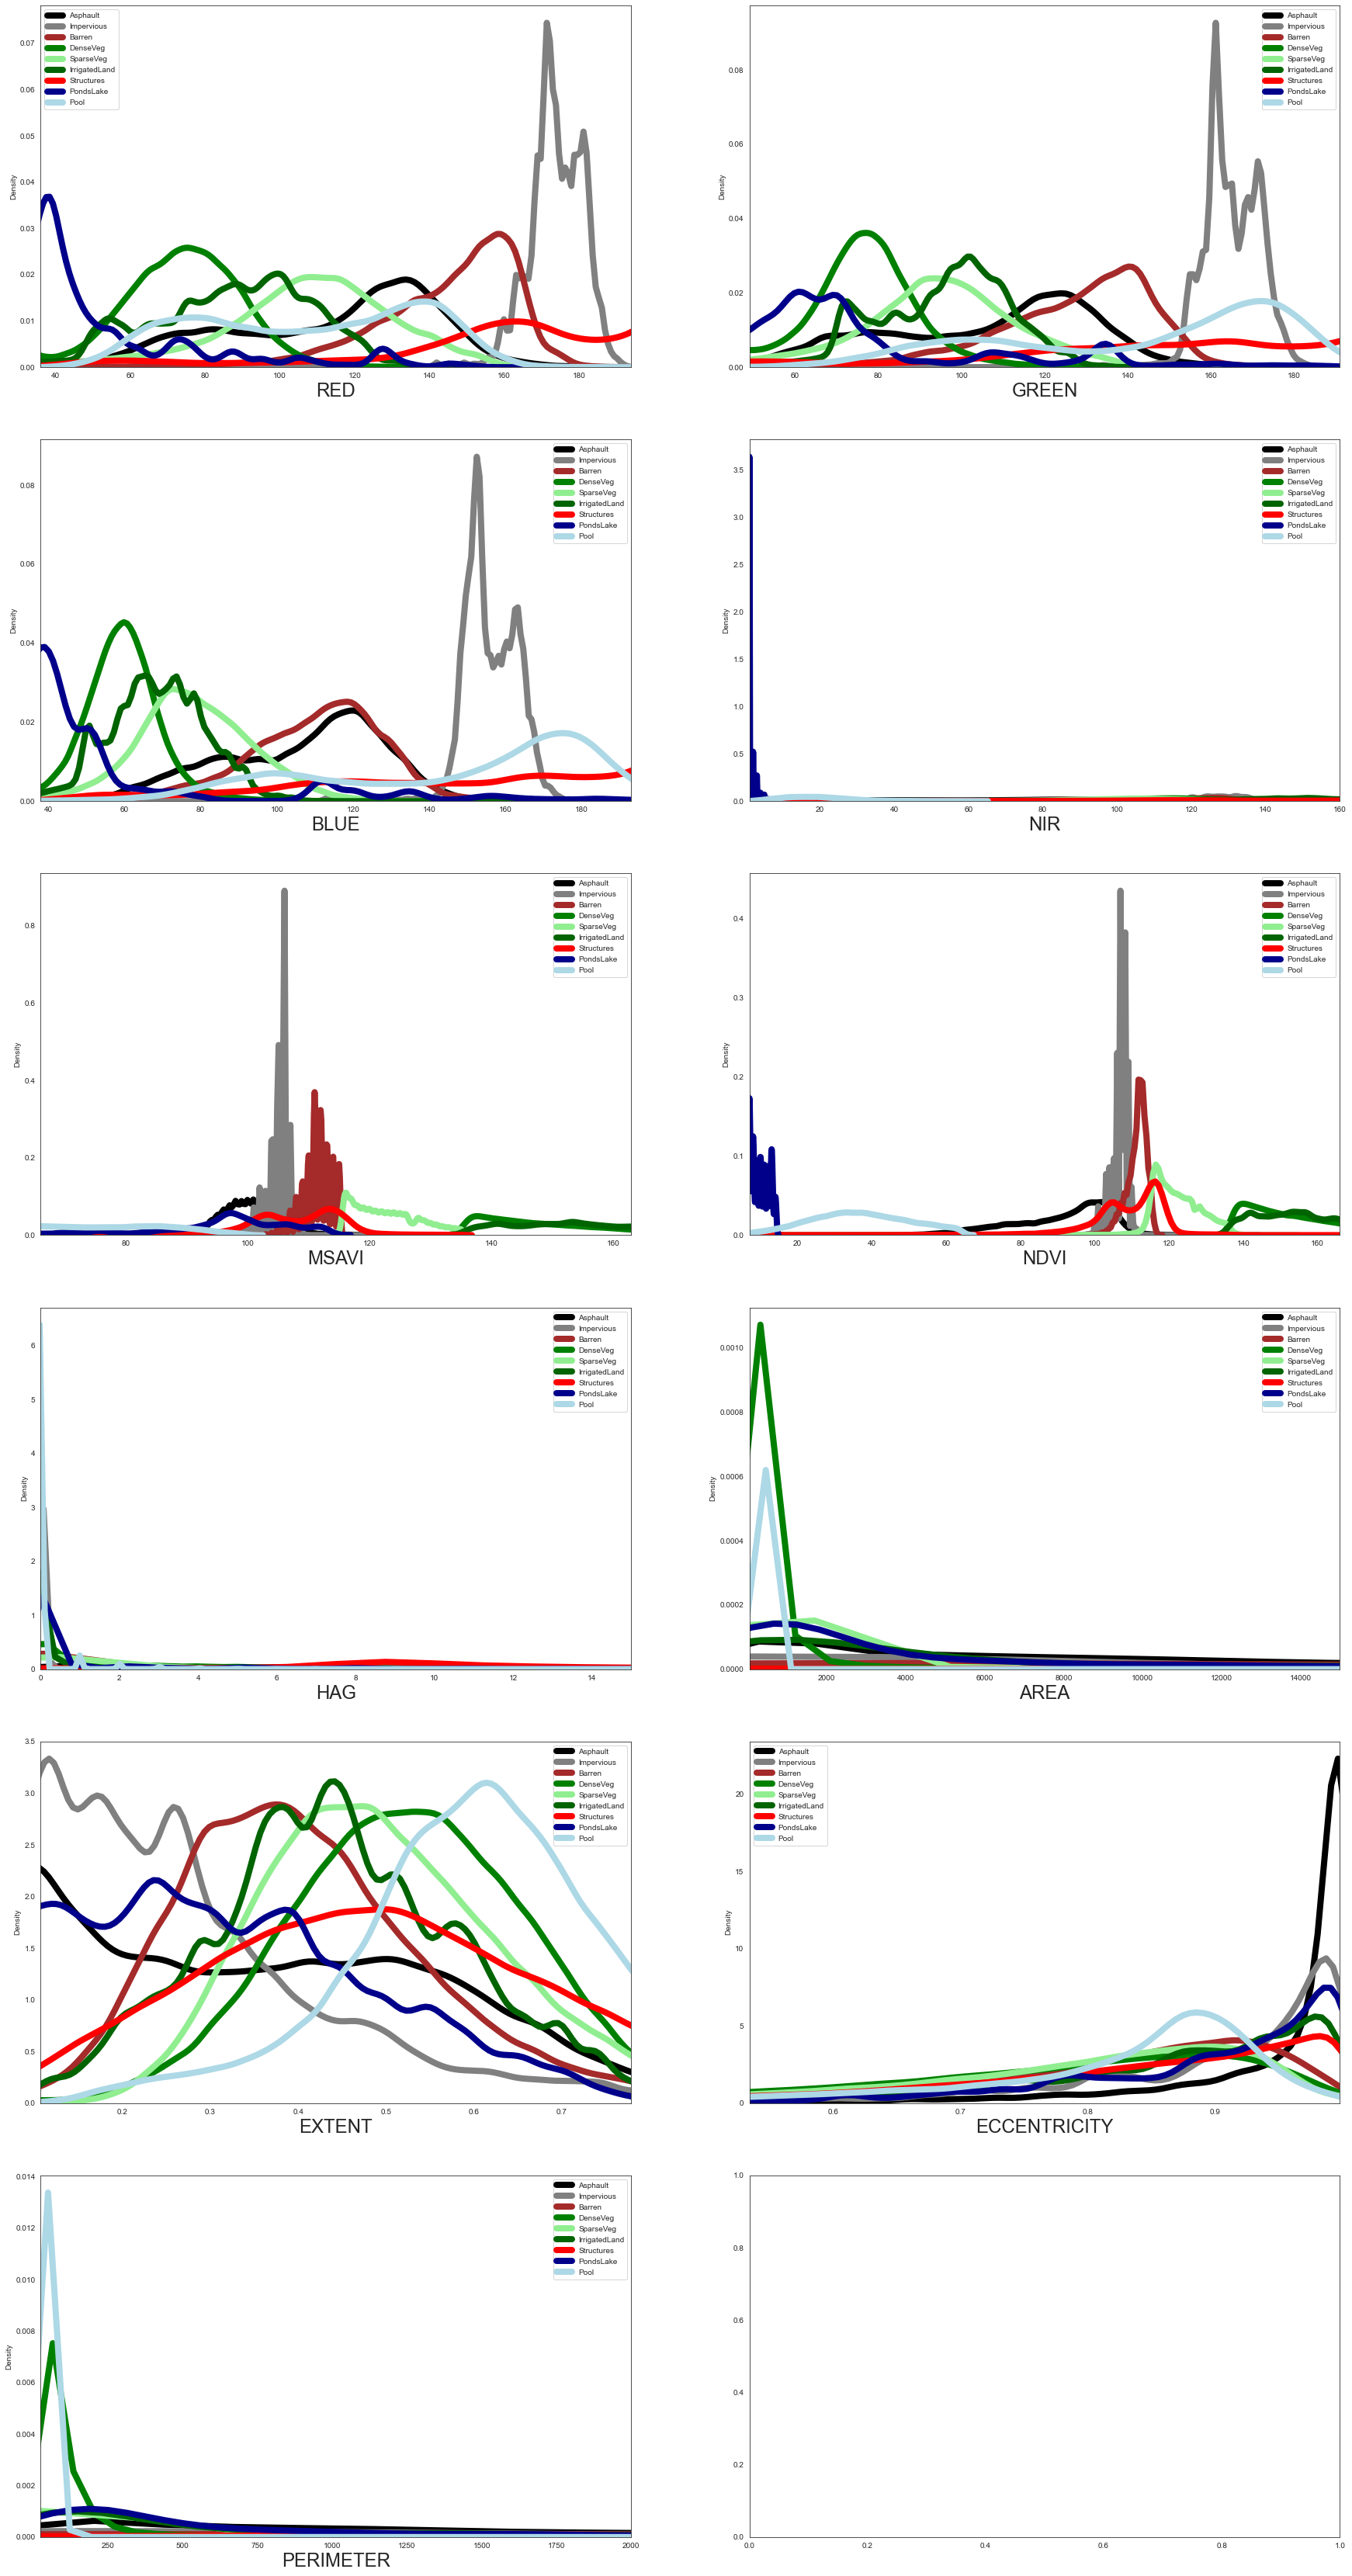

In [56]:
import seaborn as sns
sns.set_style("white")

# Plot
av = 0.6

features = ["RED","GREEN","BLUE","NIR","MSAVI","NDVI","HAG","area","extent","eccentricity","perimeter"]
columns = 2
rows = math.ceil(len(features)/columns)
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize = (30, rows * 10))

kwargs = {'linewidth': 8, "alpha":0.5}#, plt.plot: {alpha:0.75}} #, line_kws={"alpha":0.75})

for i, ax in enumerate(fig.axes):
    if i >= len(features):
        continue
    column = features[i]
    sns.kdeplot(subsamp[subsamp.LCClass=="Asphault"][column], color="black", label="Asphault", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="Impervious"][column], color="grey", label="Impervious", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="Barren"][column], color="brown", label="Barren", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="DenseVeg"][column], color="green", label="DenseVeg", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="SparseVeg"][column], color="lightgreen", label="SparseVeg", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="IrrigatedLand"][column], color="darkgreen", label="IrrigatedLand", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="Structures"][column], color="red", label="Structures", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="PondsLake"][column], color="darkblue", label="PondsLake", ax=ax, **kwargs)
    sns.kdeplot(subsamp[subsamp.LCClass=="Pool"][column], color="lightblue", label="Pool", ax=ax, **kwargs)

    ax.legend()
    if column == "HAG":
        xUpperLim = 15
        yUpperLim = 3
    elif column == "area":
        xUpperLim = 15000
    elif column == "perimeter":
        xUpperLim = 2000
    else:
        xUpperLim = np.percentile(subsamp[column],95)
    xLowerLim = np.percentile(subsamp[column],5)
    ax.set_xlim(xLowerLim, xUpperLim)
    ax.set_xlabel( column.upper() , size=24 ) 
    
%chime

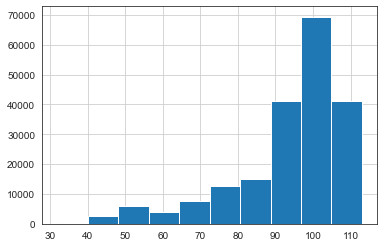

In [57]:
subsamp[subsamp.LCClass=="PondsLake"]["MSAVI"].hist()

In [17]:
subsamp

,RED,GREEN,BLUE,NIR,MSAVI,NDVI,HAG,area,extent,eccentricity,perimeter,X,Y,LCClass
42766306,134,125,120,88,103,101,0,13504.0,0.158004,0.873278,1176.093506,NaN,NaN,Asphault
40875648,146,136,132,103,105,105,0,9014.0,0.513443,0.998071,1031.037598,NaN,NaN,Asphault
43589108,117,108,103,67,98,92,0,6732.0,0.752683,0.999715,1168.953369,NaN,NaN,Asphault
40295848,71,68,84,23,94,62,0,24092.0,0.525739,0.999563,2600.619385,NaN,NaN,Asphault
40746918,85,80,91,37,96,77,0,13562.0,0.155131,0.954361,1736.799194,NaN,NaN,Asphault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58073798,223,225,227,186,113,115,9,479.0,0.325850,0.977920,114.267029,NaN,NaN,Structures
58332715,217,218,223,178,112,114,16,1747.0,0.303299,0.991745,476.954376,NaN,NaN,Structures
55605962,159,160,163,114,105,106,9,1227.0,0.731664,0.622096,168.426407,NaN,NaN,Structures
60714624,158,145,135,112,105,105,10,2348.0,0.642935,0.875962,408.651794,NaN,NaN,Structures


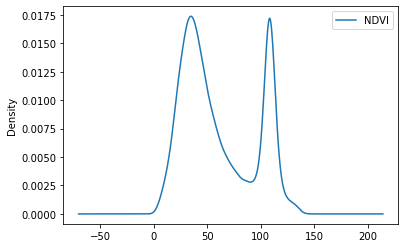

In [23]:
subsamp[subsamp.LCClass=="Pool"].plot.kde(y="NDVI")

In [32]:
pools = trainingSamples[trainingSamples.LCClass=="Pool"]
pools["geometry"] = pools.apply(lambda r: Point(r.X,r.Y), axis=1)

<ipython-input-32-46eccaa30099>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pools["geometry"] = pools.apply(lambda r: Point(r.X,r.Y), axis=1)


In [33]:
pools = gpd.GeoDataFrame(pools, geometry="geometry", crs="epsg:2868")
pools.to_file("PoolsTrainingPoints_20210304.gpkg", driver="GPKG")

In [34]:
%chime